<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/FunAPI_tf2_mnist_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar base de datos MNIST

In [0]:
#librerias principales
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier #wrapper keras sklearn
import tensorflow_probability as tfp

In [2]:
#cargar datos
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()
Xtrain = Xtrain/255 #obligar a flotante normalizado 0 a 1
Xtest = Xtest/255
print(Xtrain.shape, Xtest.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


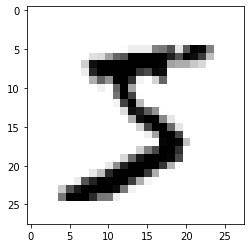

In [3]:
plt.imshow(Xtrain[0],cmap='binary')

# Generar dos tipos de entrada y dos tipos de salida

Valores etiquetas: [0 1 2 3 4 5 6 7 8 9]


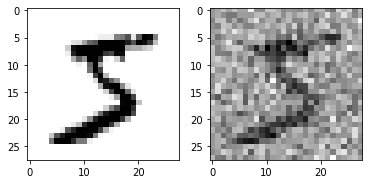

In [4]:
#agregar salida extra
print('Valores etiquetas:',np.unique(ytrain))
ytrainB = np.zeros((ytrain.shape[0]))
ytestB = np.zeros((ytest.shape[0]))
ytrainB[ytrain % 2 == 0] = 1 #salida divisor de 2
ytestB[ytest % 2 == 0] = 1 #salida divisor de 2

#agregar entrada extra 
var = 0.1 #varianza ruido
XtrainB = Xtrain + np.sqrt(var)*np.random.randn(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2])
XtestB = Xtest + np.sqrt(var)*np.random.randn(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2])

#ejemplo entrada con y sin ruido
fig, ax = plt.subplots(1,2)
fig.figsize = (4,4)
ax[0].imshow(Xtrain[0],cmap='binary')
ax[1].imshow(XtrainB[0],cmap='binary')
plt.show()


# Arquitectura por api funcional

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           entradaA[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           entradaB[0][0]                   
______________________________________________________________________________________________

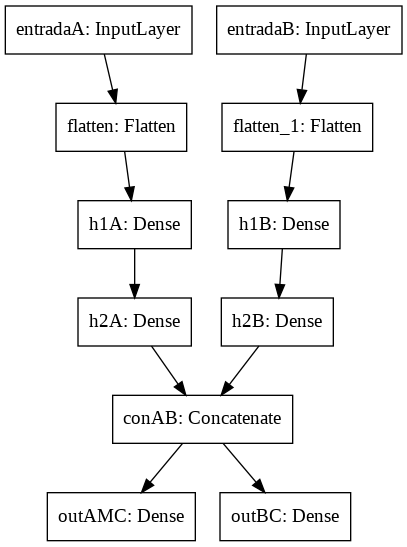

In [24]:
#ejemplo secuencial
'''
#definir arquitectura secuencial
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])),
    tf.keras.layers.Dense(200,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="tanh",name='hred2'),
    tf.keras.layers.Dense(10,activation='softmax',name='output')
])

model.summary()
tf.keras.utils.plot_model(model)
'''

#ejemplo funcional
tf.keras.backend.clear_session()

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2]), name='entradaB')
Q1 = 100
Q2 = 20
l1 = 1e-3
l2 = 1e-3
flattenA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
flattenB = tf.keras.layers.Flatten(input_shape=(XtrainB.shape[1],XtrainB.shape[2]))(inputB)

h1A = tf.keras.layers.Dense(Q1,activation='tanh',name='h1A',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)
h1B = tf.keras.layers.Dense(Q2,activation='tanh',name='h1B',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)

h2A = tf.keras.layers.Dense(Q2,activation='tanh',name='h2A')(h1A)
h2B = tf.keras.layers.Dense(Q2,activation='tanh',name='h2B')(h1B)

concAB = tf.keras.layers.concatenate([h2A,h2B],name='conAB')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(concAB) #salida multiclase
outputB = tf.keras.layers.Dense(1,activation="sigmoid",name='outBC')(concAB) #salida biclase
model_fun = tf.keras.Model(inputs=[inputA,inputB],outputs=[outputA,outputB])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

In [25]:
#compilar modelo y entrenar

model_fun.compile(loss=["sparse_categorical_crossentropy",tf.keras.losses.BinaryCrossentropy()], #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              loss_weights = [0.5,0.5],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model_fun.fit(x =[Xtrain,XtrainB], y=[ytrain,ytrainB], 
                        epochs=30,batch_size=64, # 32, 64, 128, 256
                         validation_split=0.3)


Epoch 1/30
657/657 [==============================] - 4s 7ms/step - loss: 1.0037 - outAMC_loss: 0.5854 - outBC_loss: 0.3023 - outAMC_accuracy: 0.8469 - outBC_accuracy: 0.8783 - val_loss: 0.5616 - val_outAMC_loss: 0.4278 - val_outBC_loss: 0.2349 - val_outAMC_accuracy: 0.8731 - val_outBC_accuracy: 0.9112
Epoch 2/30
657/657 [==============================] - 4s 6ms/step - loss: 0.5205 - outAMC_loss: 0.3917 - outBC_loss: 0.2138 - outAMC_accuracy: 0.8863 - outBC_accuracy: 0.9206 - val_loss: 0.5048 - val_outAMC_loss: 0.3938 - val_outBC_loss: 0.1979 - val_outAMC_accuracy: 0.8833 - val_outBC_accuracy: 0.9305
Epoch 3/30
657/657 [==============================] - 4s 6ms/step - loss: 0.4655 - outAMC_loss: 0.3481 - outBC_loss: 0.1753 - outAMC_accuracy: 0.8961 - outBC_accuracy: 0.9366 - val_loss: 0.4532 - val_outAMC_loss: 0.3461 - val_outBC_loss: 0.1598 - val_outAMC_accuracy: 0.8982 - val_outBC_accuracy: 0.9448
Epoch 4/30
657/657 [==============================] - 4s 6ms/step - loss: 0.4293 - outAM

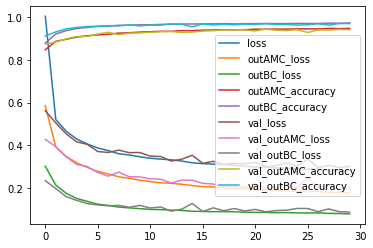

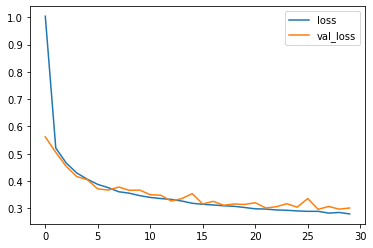

In [26]:
#graficar historial convergencia
import pandas as pd
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

In [0]:
#matriz de confusion
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

(10000, 10)
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.95      0.95      1032
           3       0.92      0.95      0.94      1010
           4       0.94      0.96      0.95       982
           5       0.90      0.93      0.92       892
           6       0.94      0.96      0.95       958
           7       0.97      0.92      0.94      1028
           8       0.93      0.94      0.94       974
           9       0.98      0.88      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

(10000, 1)
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      5074
         1.0       0.96      0.98      0.97      4926

    accuracy                           0.97   

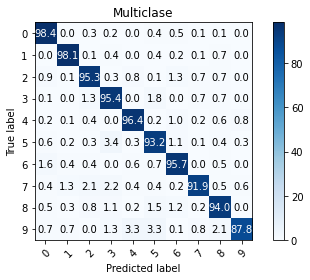

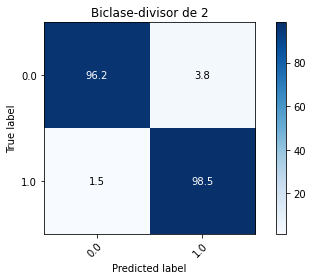

In [28]:
#conjunto de test 
ytest_e,ytest_eB = model_fun.predict([Xtest,XtestB])
print(ytest_e.shape)
plot_confusion_matrix(ytest, ytest_e.argmax(axis=1),classes=np.unique(ytest))
plt.title('Multiclase')
print(classification_report(ytest, ytest_e.argmax(axis=1)))

print(ytest_eB.shape)
print(np.unique(np.round(ytest_eB)))
plot_confusion_matrix(ytestB, np.round(ytest_eB),classes=np.unique(ytestB))
plt.title('Biclase-divisor de 2')
print(classification_report(ytestB, np.round(ytest_eB)))




2 [[1.]]


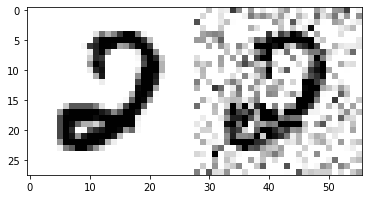

In [29]:
ii = 400
pe,peb = model_fun.predict([Xtest[ii][np.newaxis,:,:],XtestB[ii][np.newaxis,:,:]])
print(pe.argmax(),np.round(peb))
plt.imshow(np.c_[Xtest[ii],XtestB[ii]],cmap='binary',vmin=0,vmax=1)
plt.show()

# Interpretar pesos red

In [30]:
model_fun.get_layer('h1A').name
#model_fun.layers[5].name


'h1A'

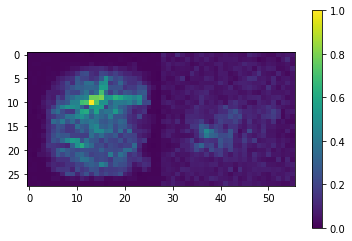

In [31]:
W1 = abs(model_fun.get_layer('h1A').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])
W2 = abs(model_fun.get_layer('h1B').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])
Wc = np.c_[W1,W2]
Wc /=np.max(Wc)
plt.imshow(Wc,vmin=0,vmax=1)
plt.colorbar()
plt.show()


# Función de perdida propia

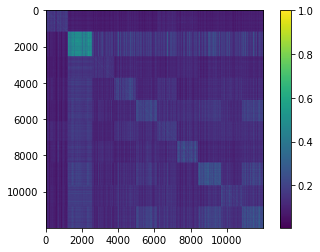

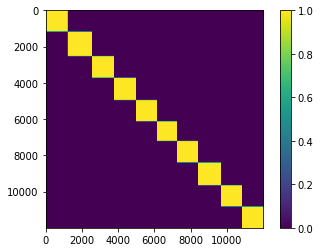

(12000, 12000)


In [32]:
#ejmplo calculos tfp
import tensorflow_probability as tfp
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#ejemplo cálculo kernels con tfp
Xtraini, _, ytraini, _= train_test_split(Xtrain,ytrain,test_size=0.8, stratify=ytrain)
ind = np.argsort(ytraini)
Xtraini = Xtraini[ind]
ytraini = ytraini[ind]
#lb = LabelBinarizer()
#ytrainb = lb.fit_transform(ytraini)

xi = tf.convert_to_tensor(Xtraini.reshape(Xtraini.shape[0],-1),dtype=tf.float32)
yi = tf.convert_to_tensor(ytraini.reshape(-1,1),dtype=tf.float32)
#kernel gaussiano tfp
scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=5)
scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
K = scalar_kernel.matrix(xi, xi)
plt.imshow(K.numpy())
plt.colorbar()
plt.show()

Ky = scalar_kernely.matrix(yi, yi)
plt.imshow(Ky.numpy())
plt.colorbar()
plt.show()
print(K.shape)

In [0]:
# Define custom loss
#centered kernel alignmet
#http://www.jmlr.org/papers/volume13/cortes12a/cortes12a.pdf
#https://www.frontiersin.org/articles/10.3389/fnins.2017.00550/full
def custom_loss(scale=5):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_cka_loss(y_true,y_pred): #ytrue labels, ypred  = Xw
      #kernels###############################################
      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
      trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
      trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
      #####funcion de costo############################################3
      f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
      return f
    # Return a function
    return custom_cka_loss



# modelo de keras con funcion de costo propia

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           entradaA[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           entradaB[0][0]                   
______________________________________________________________________________________________

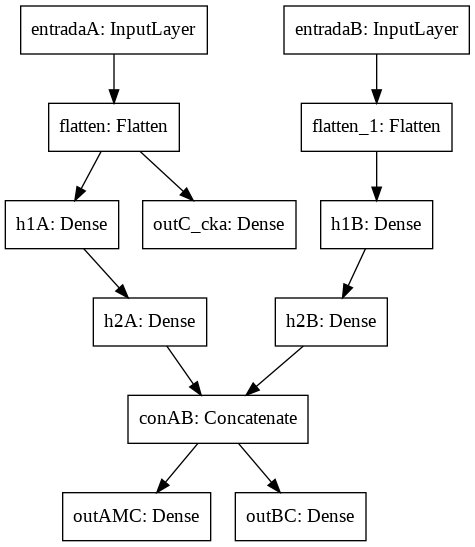

In [38]:
#ejemplo funcional
tf.keras.backend.clear_session()

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2]), name='entradaB')
Q1 = 100
Q2 = 20
l1 = 1e-3
l2 = 1e-3
flattenA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
flattenB = tf.keras.layers.Flatten(input_shape=(XtrainB.shape[1],XtrainB.shape[2]))(inputB)

h1A = tf.keras.layers.Dense(Q1,activation='tanh',name='h1A',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)
h1B = tf.keras.layers.Dense(Q2,activation='tanh',name='h1B',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)

h2A = tf.keras.layers.Dense(Q2,activation='tanh',name='h2A')(h1A)
h2B = tf.keras.layers.Dense(Q2,activation='tanh',name='h2B')(h1B)

concAB = tf.keras.layers.concatenate([h2A,h2B],name='conAB')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(concAB) #salida multiclase
outputB = tf.keras.layers.Dense(1,activation="sigmoid",name='outBC')(concAB) #salida biclase
outputC = tf.keras.layers.Dense(3,activation="linear",use_bias=False,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),
                                name='outC_cka')(flattenA) #salida rotacion Lineal con cka

model_fun = tf.keras.Model(inputs=[inputA,inputB],outputs=[outputA,outputB,outputC])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

In [39]:
#compilar modelo y entrenar con funcion propia de perdida

model_fun.compile(loss=[tf.keras.losses.SparseCategoricalCrossentropy(),tf.keras.losses.BinaryCrossentropy(),
                        custom_loss(scale=5)], 
              loss_weights = [0.3,0.3,0.4],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model_fun.fit(x =[Xtrain,XtrainB], y=[ytrain,ytrainB,ytrain], 
                        epochs=30,batch_size=64, # 32, 64, 128, 256
                         validation_split=0.3)

Epoch 1/30
657/657 [==============================] - 7s 10ms/step - loss: 0.5707 - outAMC_loss: 0.6407 - outBC_loss: 0.3264 - outC_cka_loss: -0.4507 - outAMC_accuracy: 0.8374 - outBC_accuracy: 0.8628 - outC_cka_accuracy: 0.1072 - val_loss: 0.2015 - val_outAMC_loss: 0.4520 - val_outBC_loss: 0.2744 - val_outC_cka_loss: -0.4724 - val_outAMC_accuracy: 0.8739 - val_outBC_accuracy: 0.8906 - val_outC_cka_accuracy: 0.1307
Epoch 2/30
657/657 [==============================] - 6s 9ms/step - loss: 0.1826 - outAMC_loss: 0.4324 - outBC_loss: 0.2464 - outC_cka_loss: -0.4666 - outAMC_accuracy: 0.8750 - outBC_accuracy: 0.9044 - outC_cka_accuracy: 0.1055 - val_loss: 0.1502 - val_outAMC_loss: 0.3832 - val_outBC_loss: 0.2217 - val_outC_cka_loss: -0.4684 - val_outAMC_accuracy: 0.8856 - val_outBC_accuracy: 0.9157 - val_outC_cka_accuracy: 0.0933
Epoch 3/30
657/657 [==============================] - 6s 9ms/step - loss: 0.1470 - outAMC_loss: 0.3847 - outBC_loss: 0.2115 - outC_cka_loss: -0.4676 - outAMC_accur

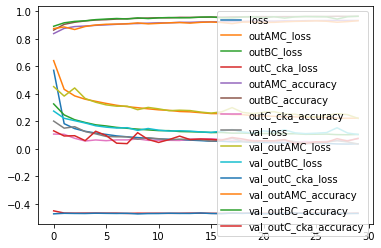

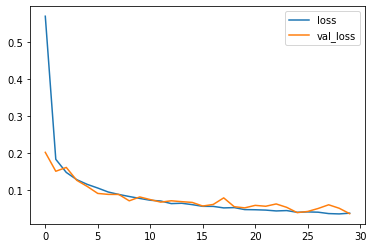

In [40]:
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

# Evaluar parte intermedia de la red

In [0]:
#crear nuevo modelo con salida parcial
model_cka = tf.keras.Model(inputs=inputA,outputs=model_fun.get_layer('outC_cka').output)
tf.keras.utils.plot_model(model_cka)
zcka = model_cka.predict(Xtrain)

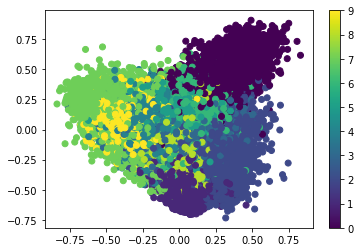

In [57]:
plt.scatter(zcka[:,0],zcka[:,1],c=ytrain)
plt.colorbar()
plt.show()

In [0]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

Streaming output truncated to the last 5000 lines.
img 5002 / 10000
img 5003 / 10000
img 5004 / 10000
img 5005 / 10000
img 5006 / 10000
img 5007 / 10000
img 5008 / 10000
img 5009 / 10000
img 5010 / 10000
img 5011 / 10000
img 5012 / 10000
img 5013 / 10000
img 5014 / 10000
img 5015 / 10000
img 5016 / 10000
img 5017 / 10000
img 5018 / 10000
img 5019 / 10000
img 5020 / 10000
img 5021 / 10000
img 5022 / 10000
img 5023 / 10000
img 5024 / 10000
img 5025 / 10000
img 5026 / 10000
img 5027 / 10000
img 5028 / 10000
img 5029 / 10000
img 5030 / 10000
img 5031 / 10000
img 5032 / 10000
img 5033 / 10000
img 5034 / 10000
img 5035 / 10000
img 5036 / 10000
img 5037 / 10000
img 5038 / 10000
img 5039 / 10000
img 5040 / 10000
img 5041 / 10000
img 5042 / 10000
img 5043 / 10000
img 5044 / 10000
img 5045 / 10000
img 5046 / 10000
img 5047 / 10000
img 5048 / 10000
img 5049 / 10000
img 5050 / 10000
img 5051 / 10000
img 5052 / 10000
img 5053 / 10000
img 5054 / 10000
img 5055 / 10000
img 5056 / 10000
img 5057 / 100

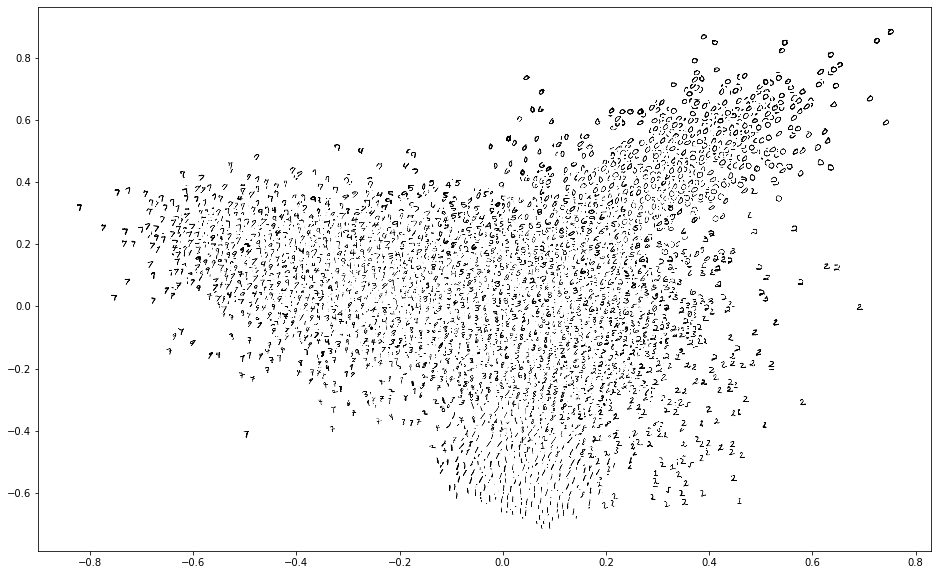

In [71]:
Ni =10000
ind = np.random.randint(0,ytrain.shape[0],Ni)
plot_mnist_2d(zcka[ind],ytrain[ind],Xtrain[ind],img_w=28,img_h=28,zoom=0.3,cmap='binary')